Best model: RandomForestRegressor
Mean Squared Error: 10055.90155986419
R2 Score: 0.9989715055508706


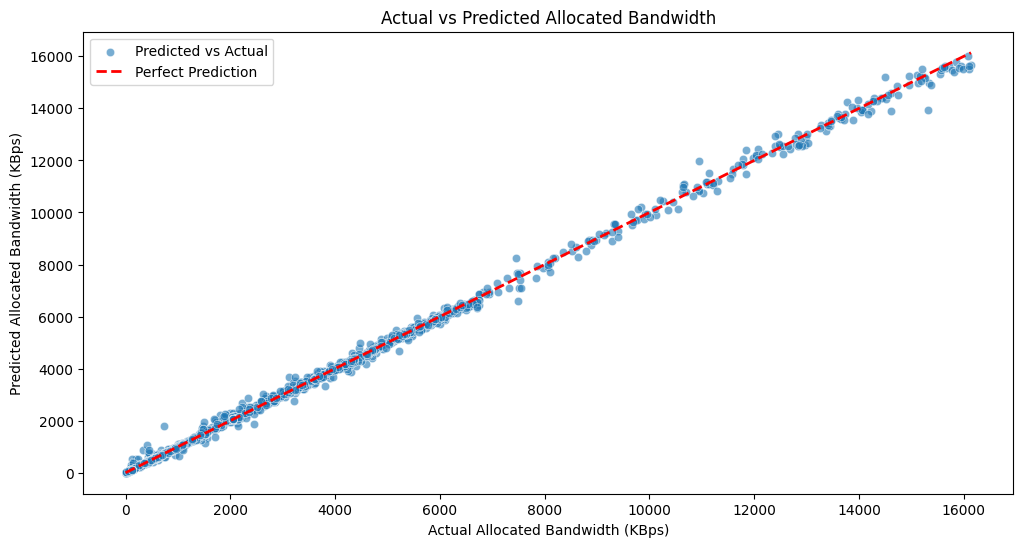

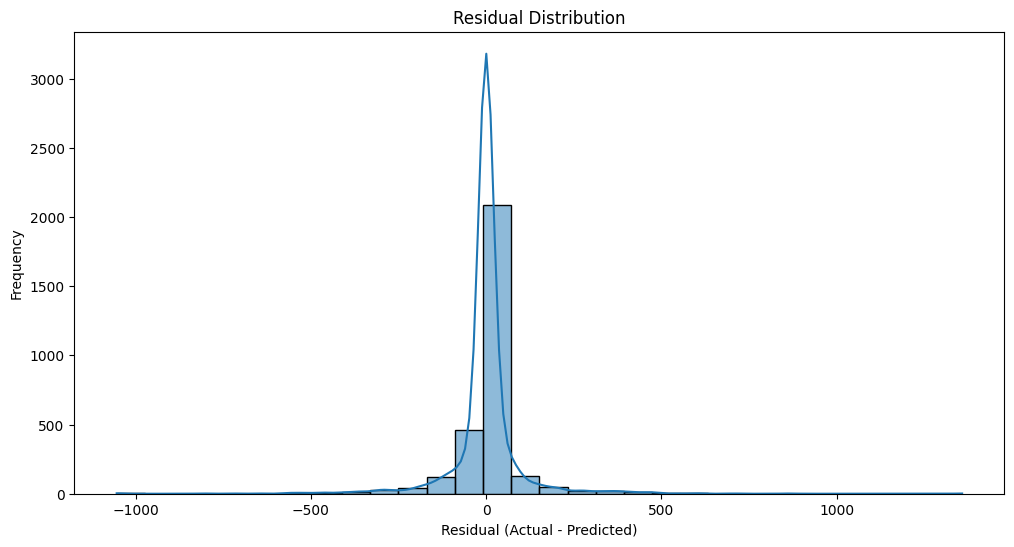

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

# Load your dataset
df = pd.read_csv('/content/preprocessed_augmented_dataset.csv')

# Prepare features and target variable
X = df[['Application_Type', 'Latency', 'Required_Bandwidth', 'Efficiency']]
y = df['Allocated_Bandwidth']

# Define preprocessor for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Latency', 'Required_Bandwidth', 'Efficiency']),
        ('cat', OneHotEncoder(sparse_output=False), ['Application_Type'])  # Ensure dense output
    ])

# Define models to evaluate
models = {
    'HistGradientBoostingRegressor': HistGradientBoostingRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'RandomForestRegressor': RandomForestRegressor()
}

# Store results
results = {}

for name, model in models.items():
    # Create a pipeline with preprocessing and model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        'MSE': mse,
        'R2': r2
    }

# Find the best model
best_model_name = max(results, key=lambda x: results[x]['R2'])
best_model = models[best_model_name]

print(f"Best model: {best_model_name}")
print(f"Mean Squared Error: {results[best_model_name]['MSE']}")
print(f"R2 Score: {results[best_model_name]['R2']}")

# Make predictions with the best model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', best_model)])
X_test_transformed = preprocessor.transform(X_test)
y_best_pred = pipeline.predict(X_test)

# Create a DataFrame for visualization
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_best_pred
}).reset_index(drop=True)

# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
sns.scatterplot(data=results_df, x='Actual', y='Predicted', alpha=0.6, label='Predicted vs Actual')
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()],
         [results_df['Actual'].min(), results_df['Actual'].max()],
         'r--', lw=2, label='Perfect Prediction')
plt.title('Actual vs Predicted Allocated Bandwidth')
plt.xlabel('Actual Allocated Bandwidth (KBps)')
plt.ylabel('Predicted Allocated Bandwidth (KBps)')
plt.legend()
plt.show()

# Plot residuals
results_df['Residual'] = results_df['Actual'] - results_df['Predicted']

plt.figure(figsize=(12, 6))
sns.histplot(results_df['Residual'], bins=30, kde=True)
plt.title('Residual Distribution')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()
